In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import struct
import os

## 1. Load MNIST dataset

In [12]:
data_dir = './digit-identifier/data'

In [40]:
## load MNIST labeled hand-written digits images
train_images = []
train_labels = []

test_images = []
test_labels = []

with open(os.path.join(data_dir, 'train-images.idx3-ubyte'), 'rb') as images_file:
    images_file.read(16)
    train_images = struct.unpack(f'{60000*28*28}B', images_file.read())

with open(os.path.join(data_dir, 'train-labels.idx1-ubyte'), 'rb') as labels_file:
    labels_file.read(8)
    train_labels = struct.unpack(f'{60000}B', labels_file.read())


with open(os.path.join(data_dir, 't10k-images.idx3-ubyte'), 'rb') as images_file:
    images_file.read(16)
    test_images = struct.unpack(f'{10000*28*28}B', images_file.read())

with open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'), 'rb') as labels_file:
    labels_file.read(8)
    test_labels = struct.unpack(f'{10000}B', labels_file.read())


In [41]:
Xtr = torch.tensor(train_images).view(60000, 28, 28) / 255
Ytr = torch.tensor(train_labels)

Xte = torch.tensor(test_images).view(10000, 28, 28) / 255
Yte = torch.tensor(test_labels)

In [42]:
Xtr.shape, Ytr.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

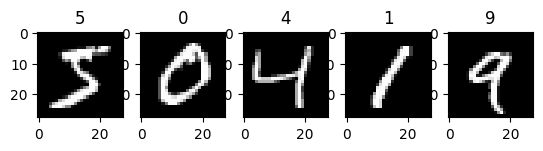

In [44]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(Xtr[i], cmap='gray')
    axs[i].set_title(Ytr[i].item())

## 2. Create Neural Network

In [87]:
W1 = torch.randn((28*28, 16)) * 5/3 * (28*28)**-0.5
b1 = torch.randn((16,)) * 0.01
W2 = torch.randn((16, 16)) * 5/3 * 16**-0.5
b2 = torch.randn((16,)) * 0.01
W3 = torch.randn((16, 10)) * 0.1
b3 = torch.randn((10,)) * 0

params = [W1, b1, W2, b2, W3, b3]
for p in params:
    p.requires_grad = True

sum(p.nelement() for p in params)

13002

## 3. Train Network

In [88]:
lossi = []

In [119]:
lr = 0.01
batch_size = 32

for i in range(50000):
    batch = torch.randint(0, Xtr.shape[0], (batch_size,))

    L1_preact = Xtr[batch].view(-1, 28*28) @ W1 + b1
    L1 = torch.tanh(L1_preact)

    L2_preact = L1 @ W2 + b2
    L2 = torch.tanh(L2_preact)

    L3 = L2 @ W3 + b3

    loss = F.cross_entropy(L3, Ytr[batch])
    lossi.append(loss.item())

    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        p.data -= lr * p.grad
    
loss

tensor(0.0734, grad_fn=<NllLossBackward0>)

### 3.1. Check quality of initialization (add a 'break' at the end of the training loop)

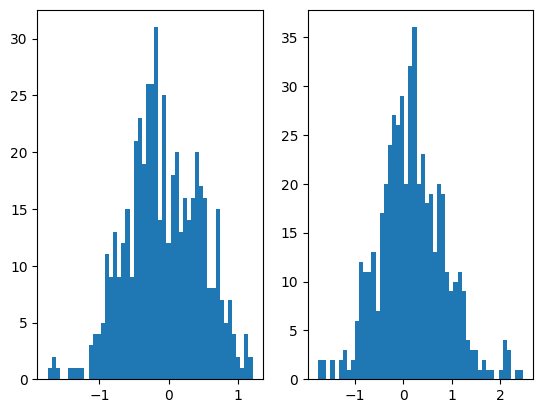

In [ ]:
## preactivations must have normal distribution, ideal for tanh
fig, axs = plt.subplots(1, 2)
axs[0].hist(L1_preact.view(-1).tolist(), 50);
axs[1].hist(L2_preact.view(-1).tolist(), 50);

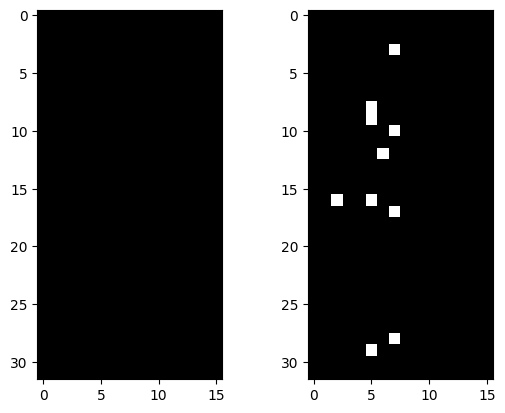

In [ ]:
## tanch activation must not be saturated so gradients flow through them
fig, axs = plt.subplots(1, 2)
axs[0].imshow(torch.abs(L1) > 0.95, cmap='gray')
axs[1].imshow(torch.abs(L2) > 0.95, cmap='gray')

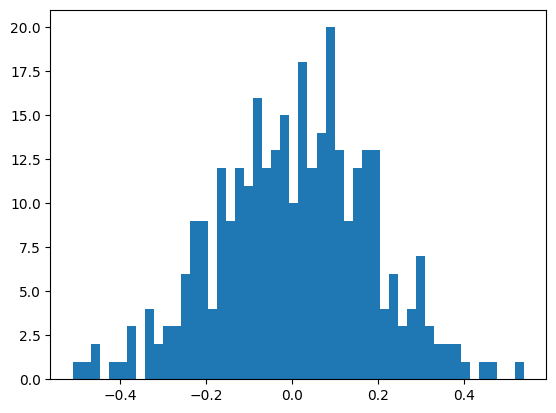

In [ ]:
## NN is not confidently wrong at initialization, probabilities are similar, saves training time
plt.hist(L3.view(-1).tolist(), 50);

In [ ]:
## loss at initialization, expected loss at initialization 
loss, -torch.log(torch.tensor(1/10))

(tensor(2.2247, grad_fn=<NllLossBackward0>), tensor(2.3026))

### 3.2. Monitor training efficacy (remove 'break' at the end of the training loop)

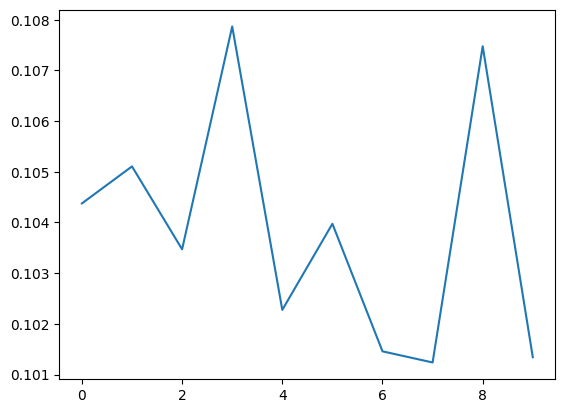

In [131]:
plt.plot(torch.tensor(lossi[-10000:]).view(-1, 1000).mean(1))

In [122]:
batch = torch.randint(0, Xte.shape[0], (1000,))
L1_preact = Xte[batch].view(-1, 28*28) @ W1 + b1
L1 = torch.tanh(L1_preact)

L2_preact = L1 @ W2 + b2
L2 = torch.tanh(L2_preact)

L3 = L2 @ W3 + b3

loss_te = F.cross_entropy(L3, Yte[batch])

loss_te, loss

(tensor(0.1819, grad_fn=<NllLossBackward0>),
 tensor(0.0734, grad_fn=<NllLossBackward0>))

## 4. Test

In [153]:
hits = 0
fails = 0
for i in range(Xte.shape[0]):
    L1 = torch.tanh(Xte[i].view(-1) @ W1 + b1)
    L2 = torch.tanh(L1 @ W2 + b2)
    L3 = L2 @ W3 + b3
    probs = torch.softmax(L3, 0)
    if (torch.max(probs, 0).indices == Yte[i]):
        hits += 1
    else:
        fails += 1

In [157]:
hits, fails, hits/(hits + fails) * 100

(9565, 435, 95.65)

## 5. Save model

In [187]:
save_path = os.path.join('digit-identifier', 'models', 'model1.nn784x16x16x10')
model = []
for p in params:
    model.extend(p.view(-1).tolist())

with open(save_path, 'wb') as out_file:
    out_file.write(struct.pack(f'{len(model)}f', *model))